# Phenogenetic architectures

## Overview

Here's where things start to get interesting. The ability to easily construct and modify phenogenetic architectures with arbitrary complexity was the core motivating feature underlying the development of `xftsim`. In what follows, we introduce the `ArchitectureComponent` and `Architecture` classes that make this possible.


:::{warning}

We highly suggest you be familiar with the `xftsim` indexers and data structures introduce [here](./indexing.ipynb) and [here](./struct.ipynb), respectively.

:::

## ArchitectureComponent objects 

An `Architecture` object largely consists of an iterable collection of `ArchitectureComponents`. These component objects take haplotype and phenotype data as inputs and modify phenotypes by reference. For example, the widely used additive genetic architecture

$$y=X\beta + e,$$
$$e \sim N(0, \sigma^2_e),$$
$$\beta \stackrel{iid}{\sim}N_m(0,\sigma^2_\beta),$$

is represented in `xftsim` as a collection of three components: the additive genetic component $X\beta$, the additive noise component $e$, and the sum transformation $y = X\beta + e$.


In [37]:
import xftsim as xft
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 240 ## better looking plots

demo = xft.sim.DemoSimulation("BGRM")
demo

<DemoSimulation>
Bivariate GCTA with balanced random mating demo

n = 2000; m = 400
Two phenotypes, height and bone mineral denisty (BMD)
assuming bivariate GCTA infinitessimal archtecture
with h2 values set to 0.5 and 0.4 for height and BMD
respectively and a genetic effect correlation of 0.0.

This architecture consists of three components:

In [38]:
len(demo.architecture.components)

3

The genetic component uses haplotype information (but not phenotype information) as inputs and generates the `additiveGenetic` phenotype component as its output:

In [39]:
demo.architecture.components[0]

<class 'xftsim.arch.AdditiveGeneticComponent'>

## INPUTS:
 - haplotypes: True
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                               phenotype_name   component_name  \
component                                                        
height.additiveGenetic.proband         height  additiveGenetic   
BMD.additiveGenetic.proband               BMD  additiveGenetic   

                                vorigin_relative     comp_type  
component                                                       
height.additiveGenetic.proband                -1  intermediate  
BMD.additiveGenetic.proband                   -1  intermediate  

The noise component, on the other hand, doesn't use haplotype information or phenotype information as inputs and generates the `additiveNoise` phenotype component as its output:

In [40]:
demo.architecture.components[1]

<class 'xftsim.arch.AdditiveNoiseComponent'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                             phenotype_name component_name  vorigin_relative  \
component                                                                      
height.additiveNoise.proband         height  additiveNoise                -1   
BMD.additiveNoise.proband               BMD  additiveNoise                -1   

                                 comp_type  
component                                   
height.additiveNoise.proband  intermediate  
BMD.additiveNoise.proband     intermediate  

Finally, the sum component ignores haplotype data but uses both the `additiveGenetic` and `additiveNoise` components to compute the `phenotype` component:

In [41]:
demo.architecture.components[2]

<class 'xftsim.arch.SumAllTransformation'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<ComponentIndex>
  2 components of 2 phenotypes spanning 1 generation
                               phenotype_name   component_name  \
component                                                        
height.additiveGenetic.proband         height  additiveGenetic   
height.additiveNoise.proband           height    additiveNoise   
BMD.additiveGenetic.proband               BMD  additiveGenetic   
BMD.additiveNoise.proband                 BMD    additiveNoise   

                                vorigin_relative     comp_type  
component                                                       
height.additiveGenetic.proband                -1  intermediate  
height.additiveNoise.proband                  -1  intermediate  
BMD.additiveGenetic.proband                   -1  intermediate  
BMD.additiveNoise.proband                     -1  intermediate  

## OUTPUTS:
 - phenotype components:
<Com

## Dependency graphs

All `ArchitectureComponent` and `Architecture` objects include a `draw_dependency_graph()` method for visualizing the dependence between components. This can be helpful for making sure your model is correctly specified. For example, the `SumAllTransformation` above has the following dependency graph:

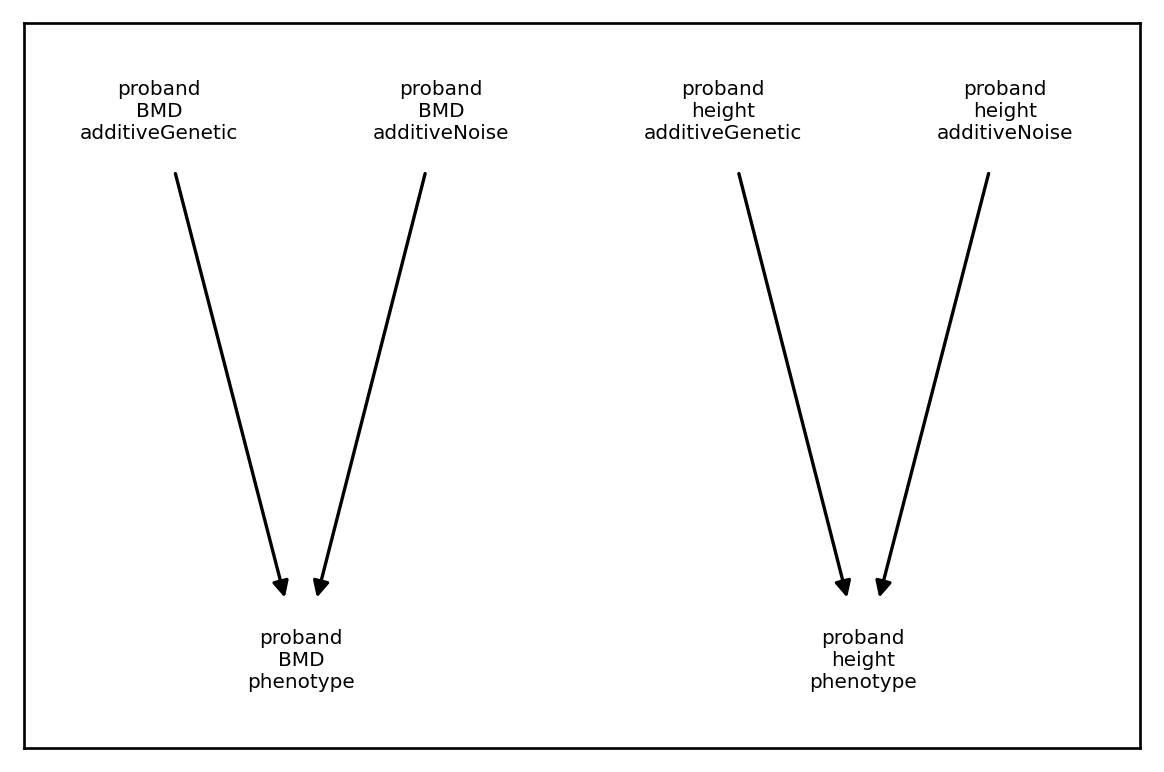

In [42]:
demo.architecture.components[2].draw_dependency_graph()

The `Architecture` object, which includes all three components has the following dependency graph:

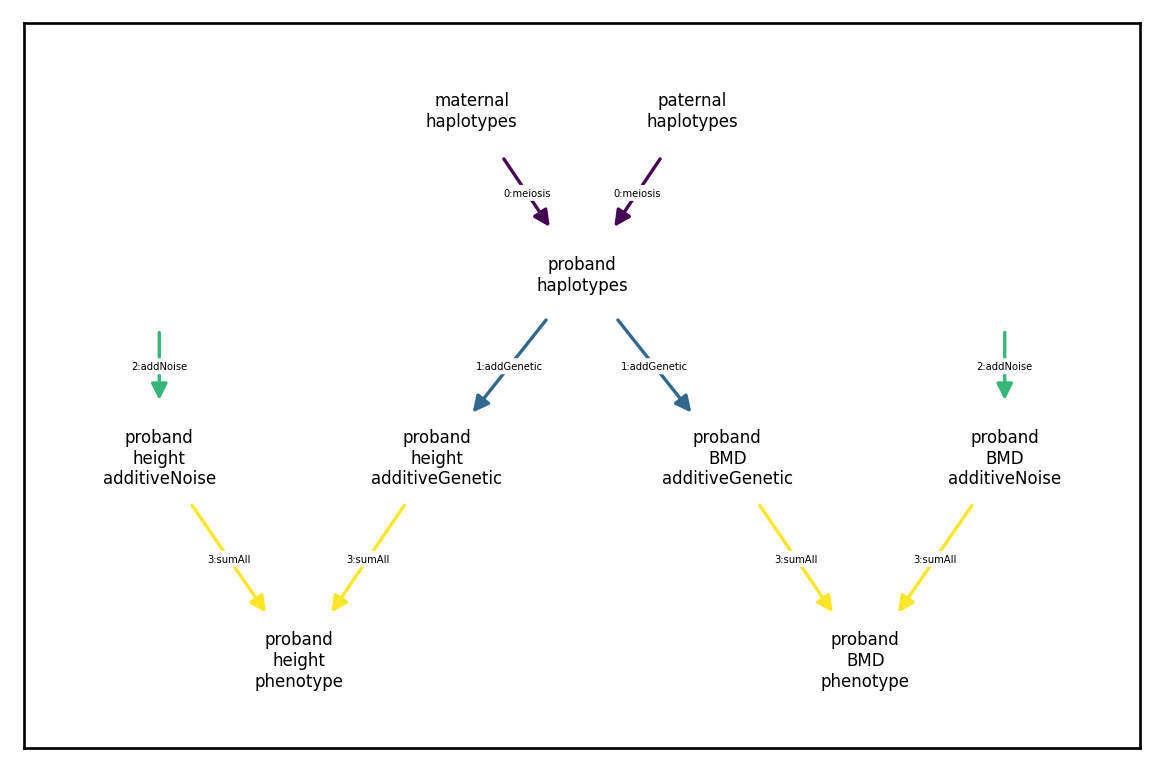

In [43]:
demo.architecture.draw_dependency_graph()

We will go through some commonly used `ArchitectureComponent`s (including the above) in what follows.

## Genetic components

To specify an 'arch.AdditiveGeneticComponent', we need to first create an `effect.AdditiveEffects` object. Additive effects relating $m$ diploid variants to $k$ phenotypic components are comprised of an $m\times k$ matrix of effects, an index of the $m$ variants (can be `xft.index.HaploidVariantIndex` or `xft.index.DiploidVariantIndex`), and an index of the $k$ components in the form of an `xft.index.ComponentIndex`. 

For example, we can create effects under the additive model specified above as follows:

In [44]:
import numpy as np

beta = np.random.randn(demo.haplotypes.xft.m, 1) * np.sqrt(.5)
vindex = demo.haplotypes.xft.get_variant_indexer()
cindex = xft.index.ComponentIndex.from_product('height', 'additiveGenetic')

effects = xft.effect.AdditiveEffects(beta=beta, 
                                     variant_indexer=vindex,
                                     component_indexer=cindex)

Alternatively, we could construct additive components for two phenotypes, height and bone mineral density (BMD), with genetic variances 0.5 and 0.4, respectively, and genetic effect correlation 0.25 as follows: 

In [45]:
m = demo.haplotypes.xft.m
vcov = np.array([[.5, .25*np.sqrt(.5*.4)],
                 [.25*np.sqrt(.5*.4), .4]])


beta = np.random.multivariate_normal(mean = np.zeros(2),
                                     cov = vcov, size = m)
vindex = demo.haplotypes.xft.get_variant_indexer()
cindex = xft.index.ComponentIndex.from_product(('height','BMD'), 'additiveGenetic')

effects = xft.effect.AdditiveEffects(beta=beta, 
                                     variant_indexer=vindex,
                                     component_indexer=cindex)

We can confirm that these effects behave as expected if desired:

In [46]:
correlation_matrix = np.corrcoef(demo.haplotypes.data @ effects.beta_unscaled_unstandardized_haploid, rowvar=-False)
covariance_matrix = np.cov(demo.haplotypes.data @ effects.beta_unscaled_unstandardized_haploid, rowvar=-False)

correlation_matrix, covariance_matrix


(array([[1.        , 0.32541182],
        [0.32541182, 1.        ]]),
 array([[0.5401159 , 0.15597649],
        [0.15597649, 0.42536784]]))

We then pass the `AdditiveEffects` object to the `AdditiveGeneticComponent` constructor to generate the corresponding archetecture component:

<class 'xftsim.arch.AdditiveGeneticComponent'>

## INPUTS:
 - haplotypes: True
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                               phenotype_name   component_name  \
component                                                        
height.additiveGenetic.proband         height  additiveGenetic   
BMD.additiveGenetic.proband               BMD  additiveGenetic   

                                vorigin_relative     comp_type  
component                                                       
height.additiveGenetic.proband                -1  intermediate  
BMD.additiveGenetic.proband                   -1  intermediate  

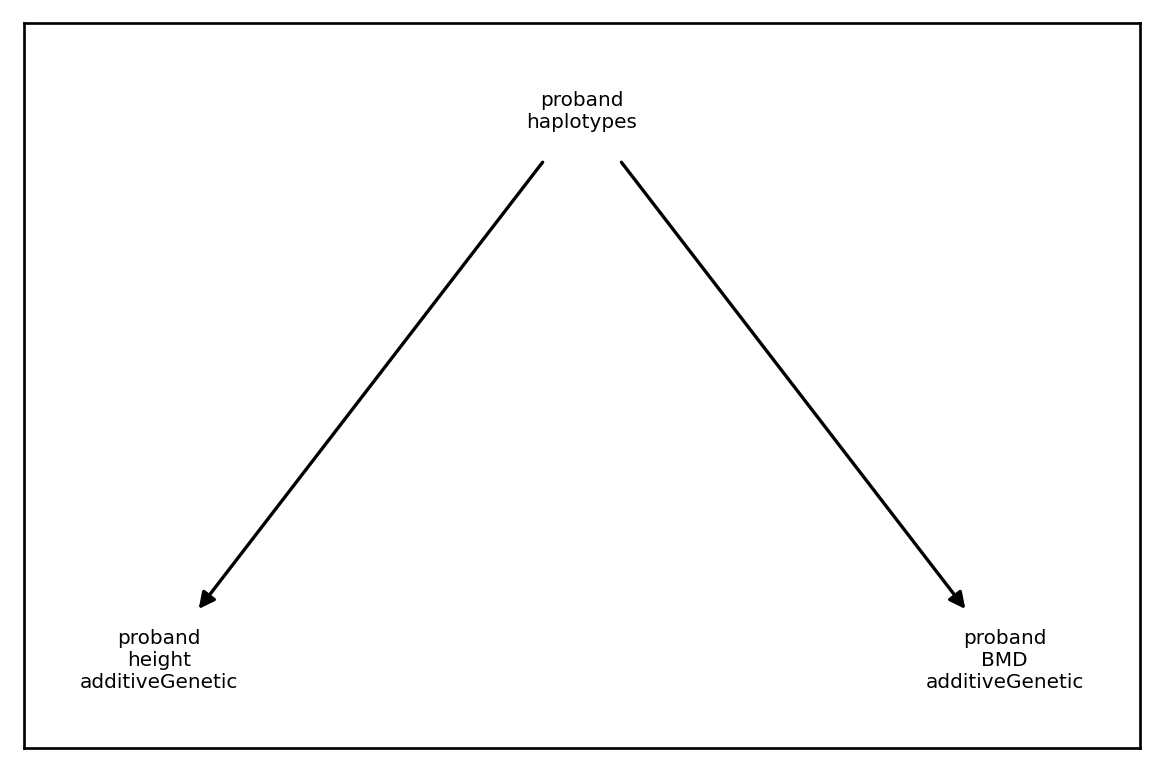

In [47]:
arch = xft.arch.AdditiveGeneticComponent(effects)
arch.draw_dependency_graph()
arch

## Noise components

Noise components are likely the simplest archetectural component to specify. For iid Gaussian noise, we only need to provide variances (or standard deviations if preferred) and the names of the corresponding phenotypes to the `AdditiveNoiseComponent` constructor. Here we construct independent noise components for height and BMD with variances 0.5 and 0.6, respectively:

In [48]:
inoise = xft.arch.AdditiveNoiseComponent(variances=[.5,.6], phenotype_name=['height', 'BMD'])
inoise

<class 'xftsim.arch.AdditiveNoiseComponent'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                             phenotype_name component_name  vorigin_relative  \
component                                                                      
height.additiveNoise.proband         height  additiveNoise                -1   
BMD.additiveNoise.proband               BMD  additiveNoise                -1   

                                 comp_type  
component                                   
height.additiveNoise.proband  intermediate  
BMD.additiveNoise.proband     intermediate  

If we want (possibly correlated) multivariate normal noise components, we can use `CorrelatedNoiseComponent` instead. Here we set the correlation between the noise components for height and BMD to 0.3:

In [49]:
vcov = np.array([[.5, .3*np.sqrt(.5*.6)],
                 [.3*np.sqrt(.5*.6), .6]])

cnoise = xft.arch.CorrelatedNoiseComponent(vcov=vcov, phenotype_name=['height', 'BMD'])
cnoise

<class 'xftsim.arch.CorrelatedNoiseComponent'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                               phenotype_name   component_name  \
component                                                        
height.correlatedNoise.proband         height  correlatedNoise   
BMD.correlatedNoise.proband               BMD  correlatedNoise   

                                vorigin_relative     comp_type  
component                                                       
height.correlatedNoise.proband                -1  intermediate  
BMD.correlatedNoise.proband                   -1  intermediate  

## Causal dependencies 

### Univariate causal dependence

We use the term "causal dependences" to refer to scenarios where one phenotype component is directly affected by another within an individual. For example, suppose I want to model years of education and income. It may reasonable to assume that regardless whatever individual heritable and/or non-heritable influences on either outcome, years of education will have some possitve effect on income (i.e., advanced degrees increase earnings). 

For simplicity, we will assume that neither trait is heritable, but that 50% of the variance in income is a linear function of years of education (which we treat here as continous for simplicity). I can model this dependence using `LinearTransformationComponent`.

One (very simple) generative model might look like this

$$\text{Edu}_\text{noise}\sim N(0,1)$$
$$\text{Income}_\text{noise}\sim N(0,.5)$$
$$\text{Edu} = \text{Edu}_\text{noise}$$
$$\text{Income}=\text{Income}_\text{noise} +\text{Edu}_\text{noise}\sqrt{.5}$$


First, we'll model the independent parts of our phenotypes. We want education to be completely random so we'll set it's variance to 1.0, whereas the independent noise for income will have variance 0.5:


In [50]:
ncomp = xft.arch.AdditiveNoiseComponent(variances=[1,.5], 
                                        phenotype_name=['edu', 'income'])
ncomp

<class 'xftsim.arch.AdditiveNoiseComponent'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<Empty ComponentIndex>

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                             phenotype_name component_name  vorigin_relative  \
component                                                                      
edu.additiveNoise.proband               edu  additiveNoise                -1   
income.additiveNoise.proband         income  additiveNoise                -1   

                                 comp_type  
component                                   
edu.additiveNoise.proband     intermediate  
income.additiveNoise.proband  intermediate  

Next, we'll add a `LinearTransformationComponent`, which requires the following arguments:
 - `input_cindex`: the ComponentIndex for the independent variable(s)
 - `output_cindex`: the ComponentIndex for the dependent variable(s)
 - `coefficient_matrix`: the matrix to premultiply the independent variables with to get the dependent variables
 - `normalize`: a boolean flag determining whether or not to standardize the independent variables prior to applying the linear transformation.
 
This will be very simple in this case as our matrix is 1x1:


In [51]:
input_ind = xft.index.ComponentIndex(['edu'], ['additiveNoise'])
output_ind = xft.index.ComponentIndex(['income'], ['dependentComponent'])
coefficient_matrix = np.array([[np.sqrt(.5)]])

ccomp = xft.arch.LinearTransformationComponent(input_ind, output_ind, 
                                               coefficient_matrix, normalize = True)
ccomp

<LinearTransformationComponent>
                                           normalized_edu additiveNoise -1 intermediate
income_dependentComponent_-1_intermediate                                      0.707107

To put everything together, can add a `SumAllTransformation`, which we'll cover in greater depth below:

<class 'xftsim.arch.SumAllTransformation'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<ComponentIndex>
  2 components of 2 phenotypes spanning 1 generation
                                  phenotype_name      component_name  \
component                                                              
edu.additiveNoise.proband                    edu       additiveNoise   
income.additiveNoise.proband              income       additiveNoise   
income.dependentComponent.proband         income  dependentComponent   

                                   vorigin_relative     comp_type  
component                                                          
edu.additiveNoise.proband                        -1  intermediate  
income.additiveNoise.proband                     -1  intermediate  
income.dependentComponent.proband                -1  intermediate  

## OUTPUTS:
 - phenotype components:
<ComponentIndex>
  1 component of 2 phenotypes spanning 1 generation
                     

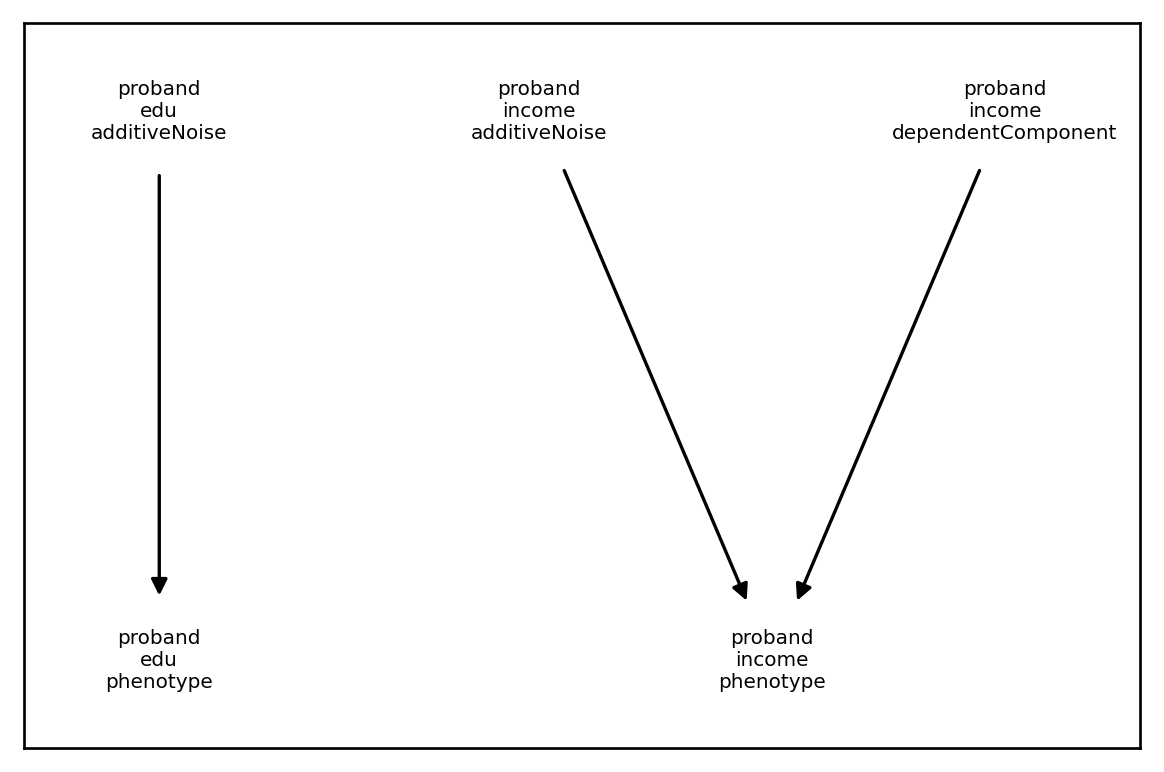

In [52]:
iind = xft.index.ComponentIndex(['edu','income','income'], 
                                ['additiveNoise','additiveNoise','dependentComponent'])

strans = xft.arch.SumAllTransformation(input_cindex=iind) 
strans.draw_dependency_graph()
strans

Looking at the result, we see that everything is is as expected:

phenotype_name                                               edu  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               1.000000   
income         additiveNoise      proband               0.000012   
               dependentComponent proband               1.000000   
edu            phenotype          proband               1.000000   
income         phenotype          proband               0.499178   

phenotype_name                                            income  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               0.000012   
income         additiveNoise      proband               1.000000   
               dependentComponent proband               0.000012   
edu            phenotype          proband               0.000012   
income         phenotype          proband               0.497309   

phenotype_name                                                         \
component_name                                     dependentComponent   
vorigin_relative                                              proband   
phenotype_name component_name     vorigin_relative                      
edu            additiveNoise      proband                    1.000000   
income         additiveNoise      proband                    0.000012   
               dependentComponent proband                    1.000000   
edu            phenotype          proband                    1.000000   
income         phenotype          proband                    0.499178   

phenotype_name                                           edu    income  
component_name                                     phenotype phenotype  
vorigin_relative                                     proband   proband  
phenotype_name component_name     vorigin_relative                      
edu            additiveNoise      proband           1.000000  0.499178  
income         additiveNoise      proband           0.000012  0.497309  
               dependentComponent proband           1.000000  0.499178  
edu            phenotype          proband           1.000000  0.499178  
income         phenotype          proband           0.499178  1.000000

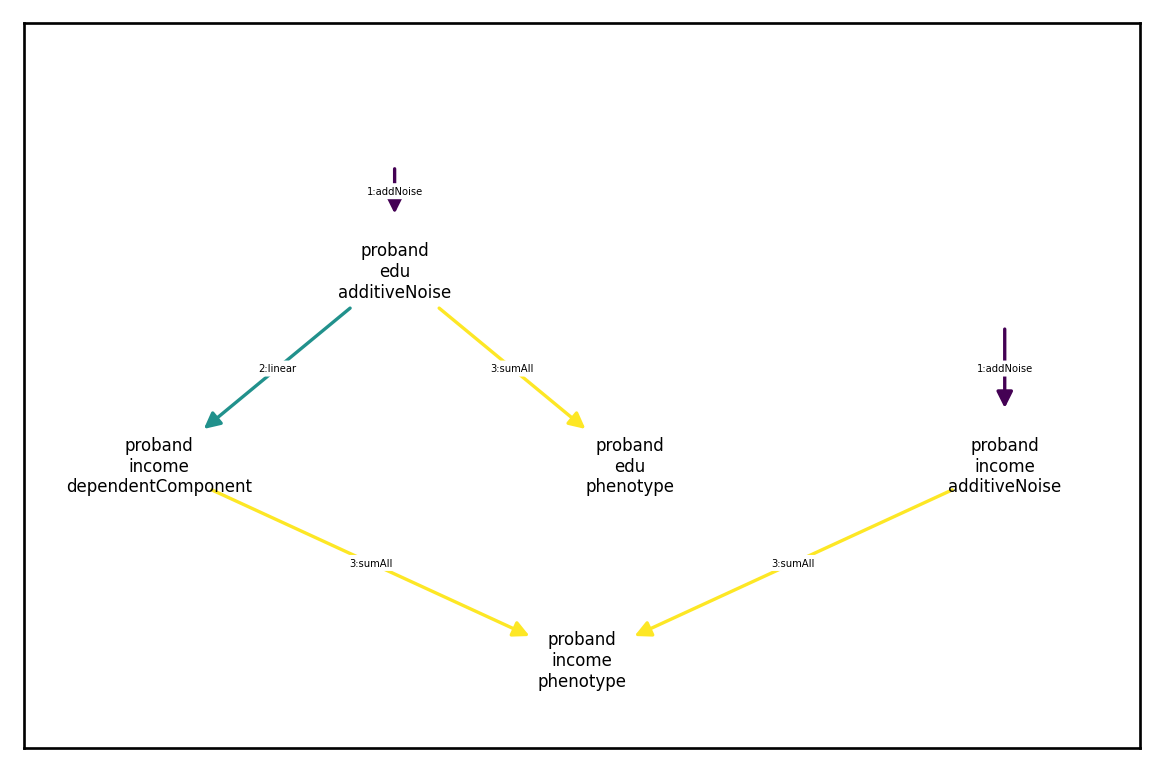

In [53]:
demo =  xft.sim.DemoSimulation()

test_sim = xft.sim.Simulation(founder_haplotypes=demo.haplotypes,
                              mating_regime=demo.mating_regime,
                              recombination_map= demo.recombination_map,
                              architecture = xft.arch.Architecture([ncomp, ccomp, strans]),
                              statistics=[xft.stats.SampleStatistics()],)

test_sim.architecture.draw_dependency_graph()
test_sim.run(1)
pd = test_sim.phenotypes.xft.as_pd()
pd.corr()**2

### Multivariate causal dependence


No suppose we assume income is affected by not just a single education factor, but by education and some measure of "opportunity".

Another simple model generative model might look like this

$$\text{Edu}_\text{noise}\sim N(0,1)$$
$$\text{Opportunity}_\text{noise}\sim N(0,1)$$
$$\text{Income}_\text{noise}\sim N(0,.5)$$
$$\text{Income}=\text{Income}_\text{noise} +\text{Edu}_\text{noise}\sqrt{.25} +\text{Opportunity}_\text{noise}\sqrt{.25}$$

In this case, everything will be the same except that our linear transformation will be 2x1:


phenotype_name                                               edu  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               1.000000   
opportunity    additiveNoise      proband               0.000449   
income         additiveNoise      proband               0.000255   
               dependentComponent proband               0.489400   
edu            phenotype          proband               1.000000   
opportunity    phenotype          proband               0.000449   
income         phenotype          proband               0.240125   

phenotype_name                                       opportunity  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               0.000449   
opportunity    additiveNoise      proband               1.000000   
income         additiveNoise      proband               0.000353   
               dependentComponent proband               0.489400   
edu            phenotype          proband               0.000449   
opportunity    phenotype          proband               1.000000   
income         phenotype          proband               0.238147   

phenotype_name                                            income  \
component_name                                     additiveNoise   
vorigin_relative                                         proband   
phenotype_name component_name     vorigin_relative                 
edu            additiveNoise      proband               0.000255   
opportunity    additiveNoise      proband               0.000353   
income         additiveNoise      proband               1.000000   
               dependentComponent proband               0.000616   
edu            phenotype          proband               0.000255   
opportunity    phenotype          proband               0.000353   
income         phenotype          proband               0.486545   

phenotype_name                                                         \
component_name                                     dependentComponent   
vorigin_relative                                              proband   
phenotype_name component_name     vorigin_relative                      
edu            additiveNoise      proband                    0.489400   
opportunity    additiveNoise      proband                    0.489400   
income         additiveNoise      proband                    0.000616   
               dependentComponent proband                    1.000000   
edu            phenotype          proband                    0.489400   
opportunity    phenotype          proband                    0.489400   
income         phenotype          proband                    0.488629   

phenotype_name                                           edu opportunity  \
component_name                                     phenotype   phenotype   
vorigin_relative                                     proband     proband   
phenotype_name component_name     vorigin_relative                         
edu            additiveNoise      proband           1.000000    0.000449   
opportunity    additiveNoise      proband           0.000449    1.000000   
income         additiveNoise      proband           0.000255    0.000353   
               dependentComponent proband           0.489400    0.489400   
edu            phenotype          proband           1.000000    0.000449   
opportunity    phenotype          proband           0.000449    1.000000   
income         phenotype          proband           0.240125    0.238147   

phenotype_name                                        income  
component_name                                   

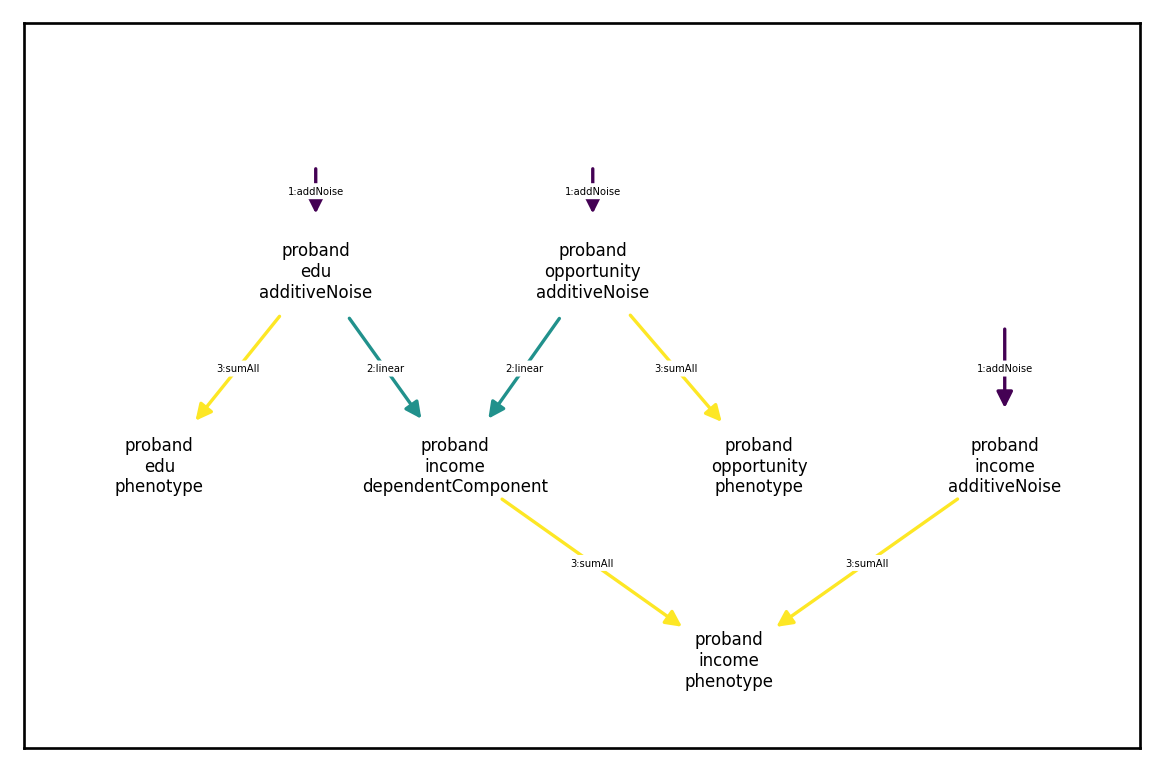

In [54]:
ncomp = xft.arch.AdditiveNoiseComponent(variances=[1,1,.5], 
                                        phenotype_name=['edu', 'opportunity', 'income'])
input_ind = xft.index.ComponentIndex(['edu','opportunity'], ['additiveNoise','additiveNoise'])
output_ind = xft.index.ComponentIndex(['income'], ['dependentComponent'])
coefficient_matrix = np.array([[np.sqrt(.25),np.sqrt(.25)]])

ccomp = xft.arch.LinearTransformationComponent(input_ind, output_ind, 
                                               coefficient_matrix, normalize = True)
sind = xft.index.ComponentIndex(['edu','opportunity','income','income'], 
                                ['additiveNoise','additiveNoise','additiveNoise','dependentComponent'])

strans = xft.arch.SumAllTransformation(input_cindex=sind) 

test_sim = xft.sim.Simulation(founder_haplotypes=demo.haplotypes,
                              mating_regime=demo.mating_regime,
                              recombination_map= demo.recombination_map,
                              architecture = xft.arch.Architecture([ncomp, ccomp, strans]),
                              statistics=[xft.stats.SampleStatistics()],)

test_sim.architecture.draw_dependency_graph()
test_sim.run(1)
pd = test_sim.phenotypes.xft.as_pd()
pd.corr()**2

## Vertical transmission

### Univariate vertical transimission

Vertical transmission refers to causal dependence across parent and offspring generations. For example, we might want to model the inheritance of wealth across generations. One generative generative model could look like this:

$$\text{Wealth}_\text{noise}\sim N(0,.5)$$
$$\text{Wealth}_\text{vertical} = (\text{Wealth}_\text{maternal} + \text{Wealth}_\text{paternal})\sqrt{(1/4)}$$
$$\text{Wealth}_\text{phenotype} = \text{Wealth}_\text{vertical} + \text{Wealth}_\text{noise}$$

I.e., half of wealth is individual specific noise and half is inherited from ones parents. 

Specifying a linear transmission like this is quite similar to the previous example of causal dependencies, only the inputs refer to parent generation (as specified by `vorigin_relative`; see [the tutorial on component indexing for further details](./indexing.ipynb)) rather than the offspring generation. However, in addition to specifying the transmission as a linear opeartion, **we have to specify a way to initialize the transmitted component in the founder generation**. By default, we set to this to independent Gaussian noise with user-supplied variance $\sigma^2_\text{founder}$ such that $\text{Wealth}_\text{vertical}$ is drawn from this distribution in the first generation (when, in the context of our simulation, no parents exist to pass on wealth).

We demonstrate this below:

<LinearVerticalComponent>
                                 wealth phenotype 0 output  \
wealth_vertical_-1_intermediate                        0.5   

                                 wealth phenotype 1 output  
wealth_vertical_-1_intermediate                        0.5  

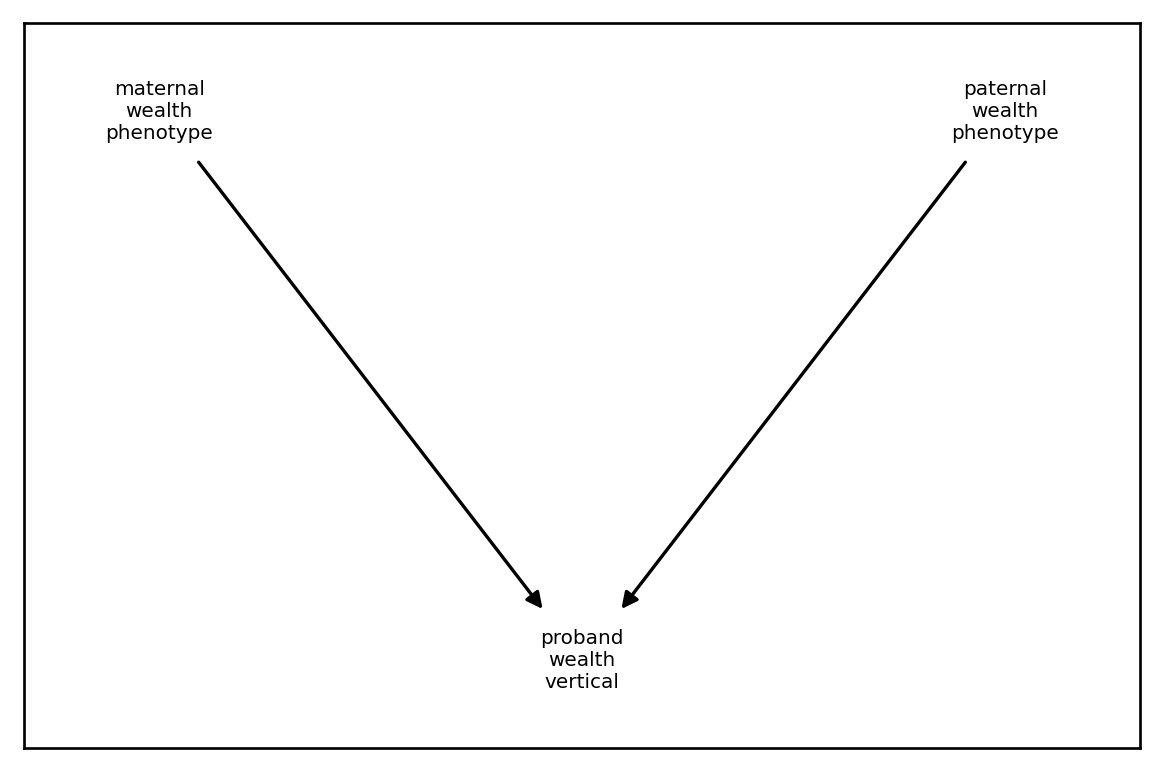

In [55]:
## noise component
ncomp = xft.arch.AdditiveNoiseComponent(variances=[.5], 
                                        phenotype_name=['wealth'])

## transmitted component:
vert_input = xft.index.ComponentIndex.from_product(['wealth'], ['phenotype'], [0,1])
vert_input.comp_type ='output'
vert_output = xft.index.ComponentIndex.from_product(['wealth'], ['vertical'], [-1])
founder_variances = np.sqrt([.5,.5]) ## must be same length is inputs
coefficient_matrix = np.array([[np.sqrt(.25),np.sqrt(.25)]])

vtcomp = xft.arch.LinearVerticalComponent(input_cindex=vert_input,
                                          output_cindex=vert_output,
                                          founder_variances=founder_variances,
                                          coefficient_matrix=coefficient_matrix,
                                          normalize = False)
vtcomp.draw_dependency_graph()
vtcomp

phenotype_name                                        wealth            \
component_name                                 additiveNoise phenotype   
vorigin_relative                                     proband    mother   
phenotype_name component_name vorigin_relative                           
wealth         additiveNoise  proband               1.000000  0.000839   
               phenotype      mother                0.000839  1.000000   
                              father                0.000270  0.001619   
               vertical       proband               0.000991  0.521693   
               phenotype      proband               0.511614  0.233929   

phenotype_name                                                                
component_name                                            vertical phenotype  
vorigin_relative                                  father   proband   proband  
phenotype_name component_name vorigin_relative                                
wealth         additiveNoise  proband           0.000270  0.000991  0.511614  
               phenotype      mother            0.001619  0.521693  0.233929  
                              father            1.000000  0.518547  0.241454  
               vertical       proband           0.518547  1.000000  0.456951  
               phenotype      proband           0.241454  0.456951  1.000000

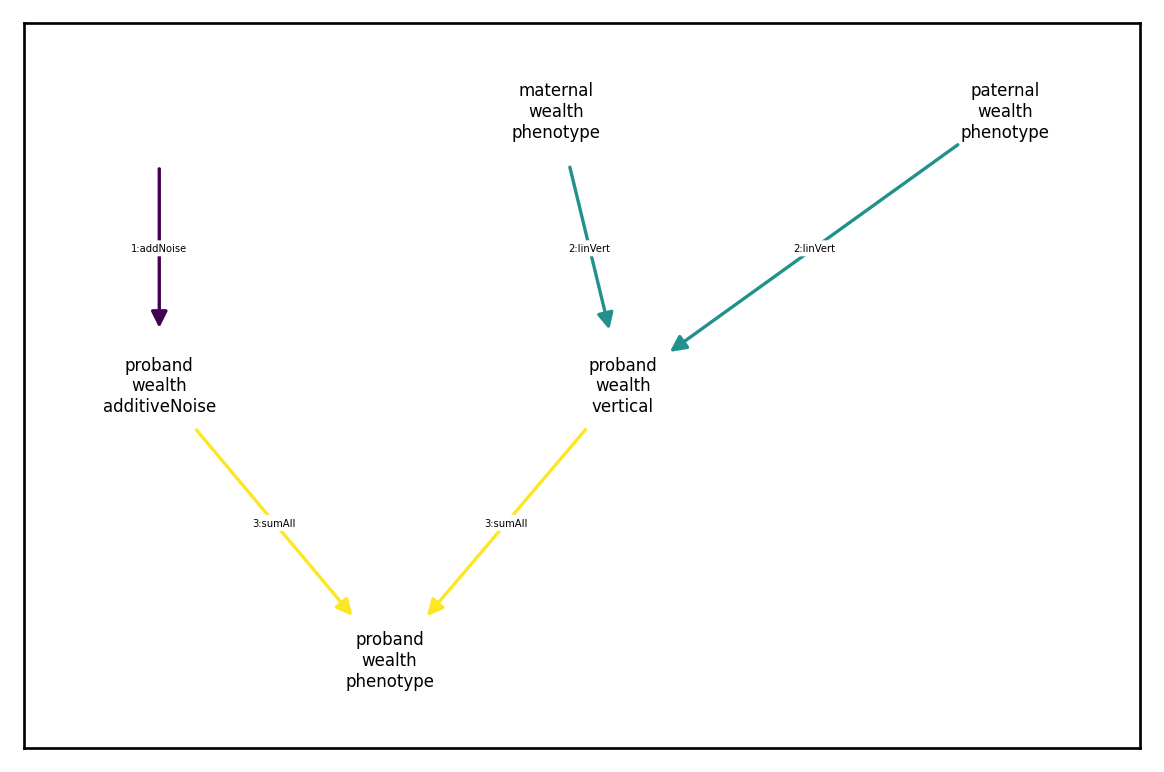

In [56]:

sind = xft.index.ComponentIndex.from_product(['wealth'],
                                             ['additiveNoise','vertical'])

strans = xft.arch.SumAllTransformation(input_cindex=sind) 

test_sim = xft.sim.Simulation(founder_haplotypes=demo.haplotypes,
                              mating_regime=demo.mating_regime,
                              recombination_map= demo.recombination_map,
                              architecture = xft.arch.Architecture([ncomp, vtcomp, strans]),
                              statistics=[xft.stats.SampleStatistics()],)
test_sim.architecture.draw_dependency_graph()
test_sim.run(2)
pd = test_sim.phenotypes.xft.as_pd()
pd.corr()**2


### Multivariate vertical transimission

We might have more complex patterns of inheritance. For example, consider the following generative model:


$$\text{Edu}_\text{noise}\sim N(0,.5)$$
$$\text{Wealth}_\text{noise}\sim N(0,.5)$$
$$\text{Edu}_\text{phenotype}=\text{Edu}_\text{inherited}+\text{Edu}_\text{noise}$$
$$\text{Wealth}_\text{phenotype}=\text{Wealth}_\text{inherited}+\text{Wealth}_\text{noise}$$


where 
$$\begin{pmatrix}\text{Edu}_{\text{inherited}}\\
\text{Wealth}_{\text{inherited}}
\end{pmatrix}\stackrel{iid}{\sim}N(0,1/2)$$
at generation zero and 
$$
\begin{pmatrix}\text{Edu}_{\text{inherited}}\\
\text{Wealth}_{\text{inherited}}
\end{pmatrix}=\begin{pmatrix}2^{-1} & 2^{-1} & 0 & 0\\
2^{-3/2} & 2^{-3/2} & 2^{-3/2} & 2^{-3/2}
\end{pmatrix}\begin{pmatrix}\tilde{\text{Edu}}_{\text{maternal}}\\
\tilde{\text{Edu}}_{\text{paternal}}\\
\tilde{\text{Wealth}}_{\text{maternal}}\\
\tilde{\text{Wealth}}_{\text{paternal}}
\end{pmatrix}$$every subsequent generation, where $\tilde{[\cdot]}$ denotes a standardized quantity. Under this model, half the variance in wealth and education are both independent Gaussian noise, half the variance in education is attributable to parental education, and a quarter each of the variance in wealth is attributable to parental education and parental wealth, respectively. We code this as follows:



<LinearVerticalComponent>
                                    normalized_education phenotype 0 output  \
education_vertical_-1_intermediate                                 0.500000   
wealth_vertical_-1_intermediate                                    0.353553   

                                    normalized_education phenotype 1 output  \
education_vertical_-1_intermediate                                 0.500000   
wealth_vertical_-1_intermediate                                    0.353553   

                                    normalized_wealth phenotype 0 output  \
education_vertical_-1_intermediate                              0.000000   
wealth_vertical_-1_intermediate                                 0.353553   

                                    normalized_wealth phenotype 1 output  
education_vertical_-1_intermediate                              0.000000  
wealth_vertical_-1_intermediate                                 0.353553  

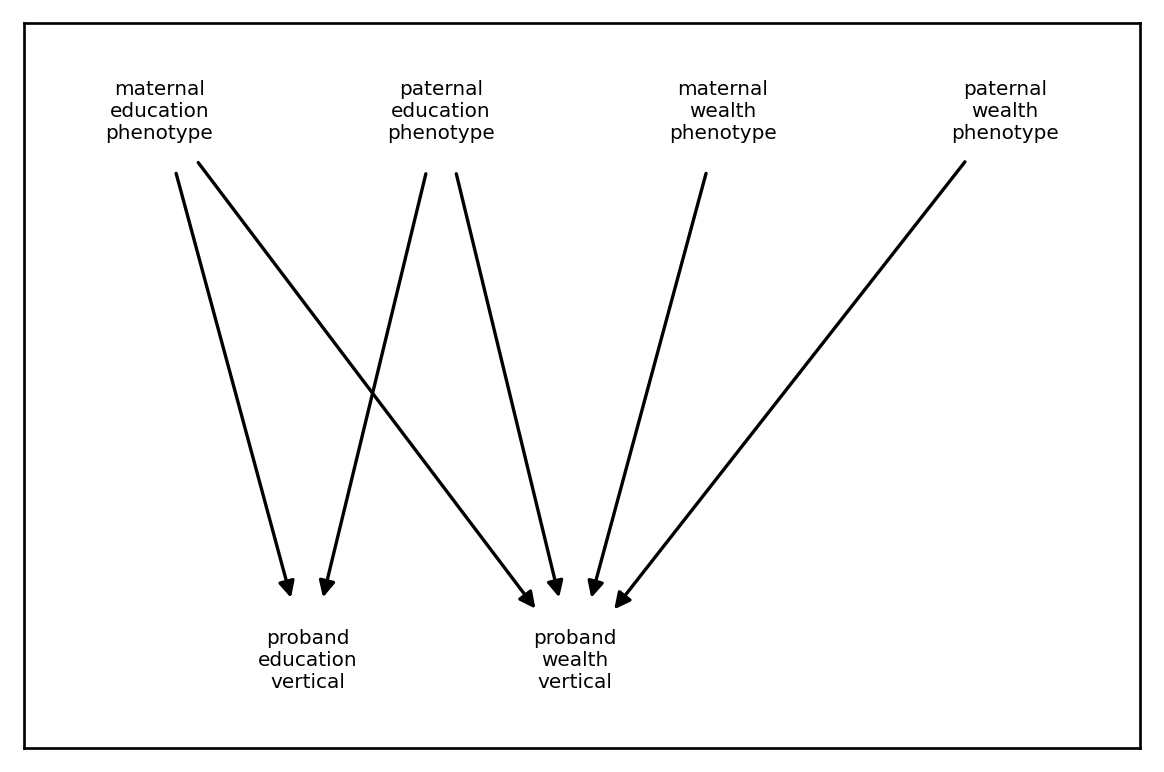

In [57]:
## noise component
ncomp = xft.arch.AdditiveNoiseComponent(variances=[.5,.5], 
                                        phenotype_name=['education', 'wealth'])

## transmitted component:
vert_input = xft.index.ComponentIndex.from_product(['education', 'wealth'], ['phenotype'], [0,1])
vert_input.comp_type ='output'
vert_output = xft.index.ComponentIndex.from_product(['education', 'wealth'], ['vertical'], [-1])
founder_variances = np.sqrt([.5,.5,.5,.5]) ## must be same length is inputs
coefficient_matrix = np.array([[np.sqrt(.25),np.sqrt(.125)],
                               [np.sqrt(.25),np.sqrt(.125)],
                               [np.sqrt(0),np.sqrt(.125)],
                               [np.sqrt(0),np.sqrt(.125)],
                              ]).T

vtcomp = xft.arch.LinearVerticalComponent(input_cindex=vert_input,
                                          output_cindex=vert_output,
                                          founder_variances=founder_variances,
                                          coefficient_matrix=coefficient_matrix,
                                          normalize = True)
vtcomp.draw_dependency_graph()
vtcomp

In [58]:

sind = xft.index.ComponentIndex.from_product(['education','wealth'],
                                             ['additiveNoise','vertical'])

strans = xft.arch.SumAllTransformation(input_cindex=sind) 

test_sim = xft.sim.Simulation(founder_haplotypes=demo.haplotypes,
                              mating_regime=demo.mating_regime,
                              recombination_map= demo.recombination_map,
                              architecture = xft.arch.Architecture([ncomp, vtcomp, strans]),
                              statistics=[xft.stats.SampleStatistics()],)

test_sim.run(1)
pd = test_sim.phenotypes.xft.as_pd()
pd.corr()**2

phenotype_name                                     education        wealth  \
component_name                                 additiveNoise additiveNoise   
vorigin_relative                                     proband       proband   
phenotype_name component_name vorigin_relative                               
education      additiveNoise  proband               1.000000  4.989915e-05   
wealth         additiveNoise  proband               0.000050  1.000000e+00   
education      phenotype      mother                0.000110  2.149450e-04   
                              father                0.000267  4.454075e-05   
wealth         phenotype      mother                0.000072  1.390822e-05   
                              father                0.000052  9.348426e-07   
education      vertical       proband               0.000018  3.254635e-05   
wealth         vertical       proband               0.000024  2.940842e-05   
education      phenotype      proband               0.499461  9.545550e-07   
wealth         phenotype      proband               0.000002  4.965587e-01   

phenotype_name                                 education              wealth  \
component_name                                 phenotype           phenotype   
vorigin_relative                                  mother    father    mother   
phenotype_name component_name vorigin_relative                                 
education      additiveNoise  proband           0.000110  0.000267  0.000072   
wealth         additiveNoise  proband           0.000215  0.000045  0.000014   
education      phenotype      mother            1.000000  0.000398  0.000041   
                              father            0.000398  1.000000  0.000548   
wealth         phenotype      mother            0.000041  0.000548  1.000000   
                              father            0.000043  0.000168  0.000064   
education      vertical       proband           0.490025  0.490025  0.000452   
wealth         vertical       proband           0.238029  0.239256  0.243537   
education      phenotype      proband           0.252694  0.233928  0.000082   
wealth         phenotype      proband           0.127056  0.117230  0.124448   

phenotype_name                                               education  \
component_name                                                vertical   
vorigin_relative                                      father   proband   
phenotype_name component_name vorigin_relative                           
education      additiveNoise  proband           5.197100e-05  0.000018   
wealth         additiveNoise  proband           9.348426e-07  0.000033   
education      phenotype      mother            4.324009e-05  0.490025   
                              father            1.675779e-04  0.490025   
wealth         phenotype      mother            6.405395e-05  0.000452   
                              father            1.000000e+00  0.000021   
education      vertical       proband           2.069801e-05  1.000000   
wealth         vertical       proband           2.618671e-01  0.487000   
education      phenotype      proband           6.947214e-05  0.496344   
wealth         phenotype      proband           1.313470e-01  0.249158   

phenotype_name                                    wealth     education  \
component_name                                  vertical     phenotype   
vorigin_relative                                 proband       proband   
phenotype_name component_name vorigin_relative                           
education      additiveNoise  proband           0.000024  4.994606e-01   
wealth         additiveNoise  proband           0.000029  9.545550e-07   
education      phenotype      mother            0.238029  2.526943e-01   
                              father            0.239256  2.339283e-01   
wealth         phenotype      mother            0.243537  8.180044e-05   
                              father            0.261867  6.947214e-05   
education

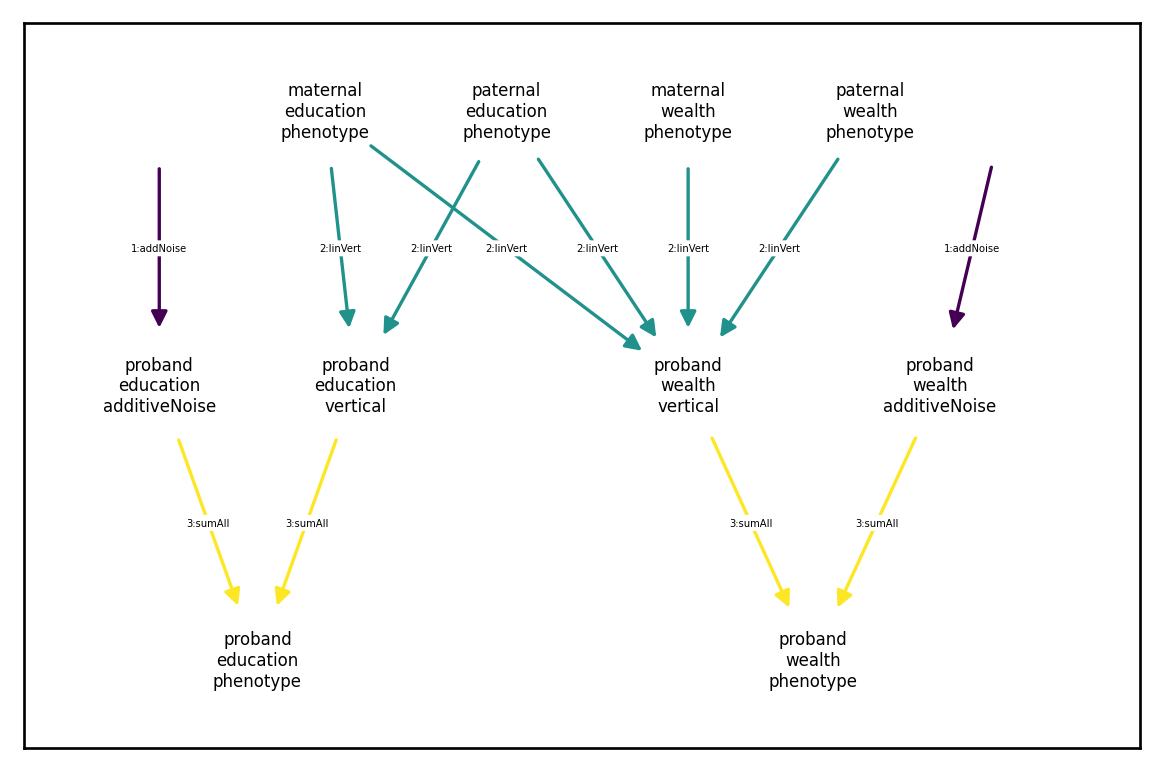

In [59]:
xft.arch.Architecture([ncomp, vtcomp, strans]).draw_dependency_graph()

## Sum transformations

We nearly always will want to include a component that sums existing components to create composite phenotypes. This is straight forward to accomplish using the `SumAllTransformation` component. To specify a `SumAllTransformation`, we only need to provide the input component index and it will sum input components corresponding to the same phenotype:


<class 'xftsim.arch.SumAllTransformation'>

## INPUTS:
 - haplotypes: False
 - phenotype components:
<ComponentIndex>
  5 components of 2 phenotypes spanning 1 generation
                       phenotype_name component_name  vorigin_relative  \
component                                                                
BMD.BMD1.proband                  BMD           BMD1                -1   
BMD.BMD2.proband                  BMD           BMD2                -1   
BMD.BMD3.proband                  BMD           BMD3                -1   
height.height1.proband         height        height1                -1   
height.height2.proband         height        height2                -1   

                           comp_type  
component                             
BMD.BMD1.proband        intermediate  
BMD.BMD2.proband        intermediate  
BMD.BMD3.proband        intermediate  
height.height1.proband  intermediate  
height.height2.proband  intermediate  

## OUTPUTS:
 - phenotype components:

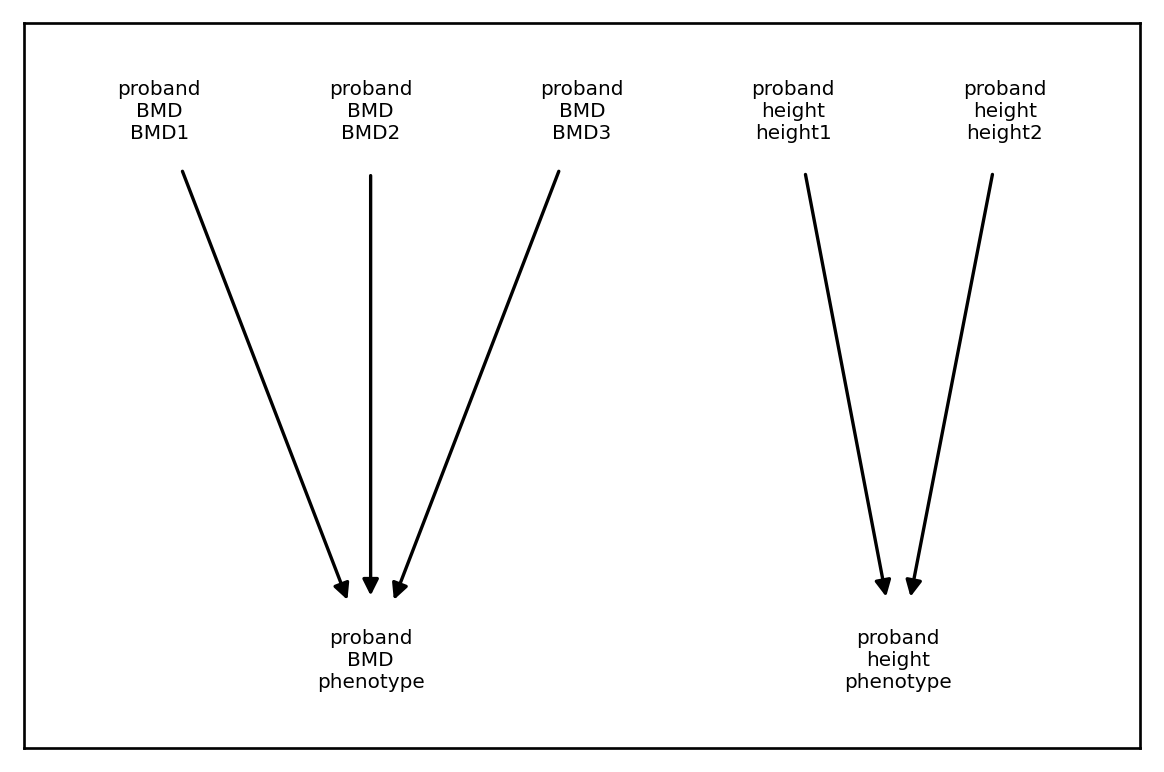

In [60]:
input_cindex=xft.index.ComponentIndex(['BMD', 'BMD', 'BMD', 'height', 'height'], 
                                      ['BMD1', 'BMD2', 'BMD3', 'height1', 'height2'])

strans = xft.arch.SumAllTransformation(input_cindex)
strans.draw_dependency_graph()
strans

## Binarizations

:::{note}

Coming soon

:::

## Architecture objects: order matters

As we have seen throughout, an `Architecture` object is nothing more than a collection of `ArchitectureComponents`. These components are constructed in order (e.g., you can't sum components that don't yet exist), and can be arbitrarily complicated. We demonstrate a complex simulation below:

![Complex simulation](../_static/complexsim.png)

Here we assume that height is heritable with heritability 0.6, but that educational attainment and wealth are not. On the other hand, we assume that the variation in educational attainment is attributable in equal parts to parental educational attainment, parental wealth, and random noise. We also assume that an individual's wealth is determined in equal parts by their own educational attainment, their parent's wealth, and random noise. Thus we have additive genetic, additive noise, multivariate vertical transmission, and causal dependence. We try to implement this in `xftsim` as follows: 


In [61]:
## This example won't work
founder_haplotypes = xft.founders.founder_haplotypes_uniform_AFs(n=4000,
                                                                 m=800)
rmap = xft.reproduce.RecombinationMap.constant_map_from_haplotypes(founder_haplotypes,
                                                                   .1)

genetic_effects = xft.effect.GCTAEffects(vg=[.6],
                                         variant_indexer=founder_haplotypes.xft.get_variant_indexer(),
                                         component_indexer=xft.index.ComponentIndex(['height'],
                                                                                    ['genetic']))
genetic_comp = xft.arch.AdditiveGeneticComponent(genetic_effects)

noise_comp = xft.arch.AdditiveNoiseComponent(variances=[.4,1/3,1/3],
                                             component_index=xft.index.ComponentIndex.from_product(['height','edu','wealth'],
                                                                                                   ['noise']))
vert_input = xft.index.ComponentIndex.from_product(['edu', 'wealth'], ['phenotype'], [0,1])
vert_input.comp_type ='output'
vert_output = xft.index.ComponentIndex.from_product(['edu', 'wealth'], ['vertical'], [-1])
founder_variances = np.sqrt([.5,.5,.5,.5]) ## must be same length is inputs
coefficient_matrix = np.array([[np.sqrt(1/3),np.sqrt(1/6)],
                               [np.sqrt(1/3),np.sqrt(1/6)],
                               [np.sqrt(0),np.sqrt(1/6)],
                               [np.sqrt(0),np.sqrt(1/6)],
                              ]).T

vt_comp = xft.arch.LinearVerticalComponent(input_cindex=vert_input,
                                          output_cindex=vert_output,
                                          founder_variances=[1.,1.,1.,1.,],
                                          coefficient_matrix=coefficient_matrix,
                                          normalize = True)
input_ind = xft.index.ComponentIndex(['edu'], ['phenotype'])
output_ind = xft.index.ComponentIndex(['wealth'], ['dependent'])
coefficient_matrix = np.array([[np.sqrt(1/3)]])

causal_comp = xft.arch.LinearTransformationComponent(input_ind, output_ind, 
                                               coefficient_matrix, normalize = True)
input_cindex=xft.index.ComponentIndex(['height','height','edu', 'edu', 'wealth', 'wealth','wealth'], 
                                      ['genetic','noise','noise', 'vertical', 'noise', 'vertical','dependent'])

strans = xft.arch.SumAllTransformation(input_cindex)

arch = xft.arch.Architecture([genetic_comp,
                              noise_comp,
                              causal_comp,
                              vt_comp,
                              strans])


/home/rsb/Dropbox/ftsim/xftsim/xftsim/arch.py:1545: UserWarning: Architecture contains out-of-order dependencies! This is probably a mistake, check dependency_graph using xft.arch.Architecture.draw_dependency_graph()
  warnings.warn('Architecture contains out-of-order dependencies! This is probably a mistake, check dependency_graph using xft.arch.Architecture.draw_dependency_graph()')
/home/rsb/Dropbox/ftsim/xftsim/xftsim/arch.py:1547: UserWarning: Architecture contains circular dependencies! This is probably a mistake, check dependency_graph using xft.arch.Architecture.draw_dependency_graph()
  warnings.warn('Architecture contains circular dependencies! This is probably a mistake, check dependency_graph using xft.arch.Architecture.draw_dependency_graph()')


In [62]:
mating = xft.mate.LinearAssortativeMatingRegime(r=.25,
                                                component_index =xft.index.ComponentIndex.from_product(['edu', 'wealth','height'], ['phenotype']), 
                                                offspring_per_pair=2,
                                                mates_per_female=1)

In [63]:
sim = xft.sim.Simulation(architecture=arch,
                   founder_haplotypes=founder_haplotypes,
                   recombination_map=rmap,
                   mating_regime=mating,
                   statistics=[xft.stats.SampleStatistics(),
                               xft.stats.MatingStatistics(),
                               xft.stats.HasemanElstonEstimator(randomized=True)])
sim.run(1)
sim.phenotypes.xft.as_pd()

phenotype_name       height                 edu    wealth       edu    wealth  \
component_name      genetic     noise     noise     noise phenotype dependent   
vorigin_relative    proband   proband   proband   proband   proband   proband   
iid    fid    sex                                                               
0_0    0_0    0   -1.438016 -0.724936 -0.365234  0.631384 -0.886001       NaN   
0_1    0_1    1   -0.736997  0.315334 -0.173979  0.863967 -0.074619       NaN   
0_2    0_2    0    0.446289 -0.205372 -1.009013  0.000586 -0.688903       NaN   
0_3    0_3    1    0.598749 -0.151390 -0.202806  0.790294  0.579928       NaN   
0_4    0_4    0    0.107083  0.488276  0.420549 -0.428935 -0.234378       NaN   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1    0.949581  0.019301  0.184719  0.539764  0.206225       NaN   
0_3996 0_3996 0    0.221268 -0.713675  1.296978  0.155919  2.684137       NaN   
0_3997 0_3997 1   -0.748438  0.288970 -1.966779  0.026904 -1.844955       NaN   
0_3998 0_3998 0    0.092972 -0.321116 -0.969225  0.568458 -0.958436       NaN   
0_3999 0_3999 1    1.053690 -0.170624 -0.130277 -0.286954 -1.313274       NaN   

phenotype_name          edu              wealth                 edu    wealth  \
component_name    phenotype           phenotype            vertical  vertical   
vorigin_relative     mother    father    mother    father   proband   proband   
iid    fid    sex                                                               
0_0    0_0    0   -1.222663  0.323357  0.631247  0.603223 -0.520767  0.133693   
0_1    0_1    1    0.987026 -0.810952  1.268394  0.609953  0.099360  0.830758   
0_2    0_2    0    0.789279 -0.233965  1.023966  1.207234  0.320110  1.128862   
0_3    0_3    1    0.984245  0.368049  0.801915 -1.369105  0.782734  0.330871   
0_4    0_4    0   -2.032368  0.899209  0.031648 -0.034985 -0.654928 -0.458581   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1   -0.954873  0.989904  1.369705  0.872761  0.021506  0.922066   
0_3996 0_3996 0    2.156972  0.239915  0.683213 -1.998439  1.387159  0.457541   
0_3997 0_3997 1    0.976374 -0.761673  1.347083  0.710631  0.121825  0.918726   
0_3998 0_3998 0    1.299026 -1.274271  0.500555 -0.861823  0.010789 -0.132018   
0_3999 0_3999 1   -1.643137 -0.397528 -0.022829  0.906682 -1.182996 -0.475214   

phenotype_name       height    wealth  
component_name    phenotype phenotype  
vorigin_relative    proband   proband  
iid    fid    sex                      
0_0    0_0    0   -2.162952       NaN  
0_1    0_1    1   -0.421664       NaN  
0_2    0_2    0    0.240917       NaN  
0_3    0_3    1    0.447359       NaN  
0_4    0_4    0    0.595359       NaN  
...                     ...       ...  
0_3995 0_3995 1    0.968881       NaN  
0_3996 0_3996 0   -0.492407       NaN  
0_3997 0_3997 1   -0.459469       NaN  
0_3998 0_3998 0   -0.228144       NaN  
0_3999 0_3999 1    0.883066       NaN  

[4000 rows x 14 columns]

It looks like the simulation wasn't able to compute the 'dependent' or 'phenotype' components of 'wealth'. What happened here? Looking at the dependency graph (which colors edges in order of computation) we see we have a circular dependency:

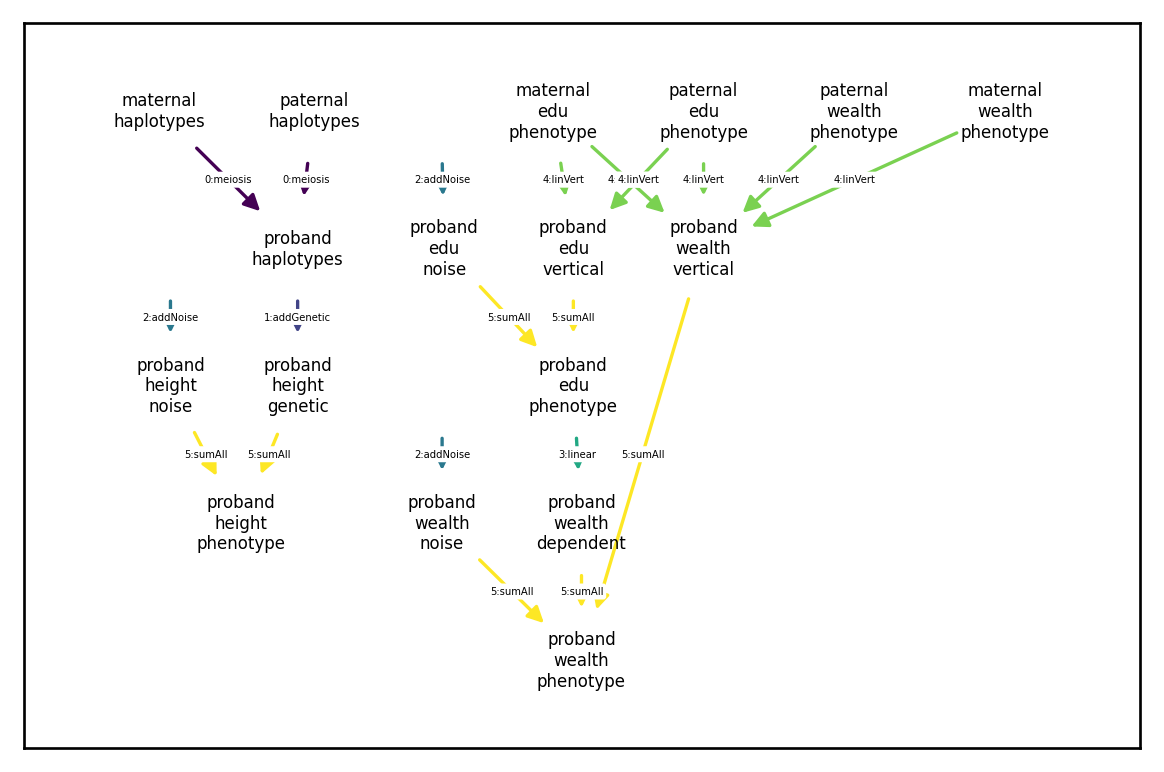

In [64]:
arch.draw_dependency_graph(font_size=5, node_size=1000)


Specifically, the `edu phenotype` node generated by the sum transformation (yellow arrows) but has a causal effect (teal arrow) on the `wealth dependent` component, which is again used by the sum transformation to construct the `wealth phenotype` component.

## Avoiding circular dependences

There are multiple ways to avoid this sort of circular dependency. The first would be to have the `wealth dependent` component depend directly on `edu noise` and `edu vertical`:



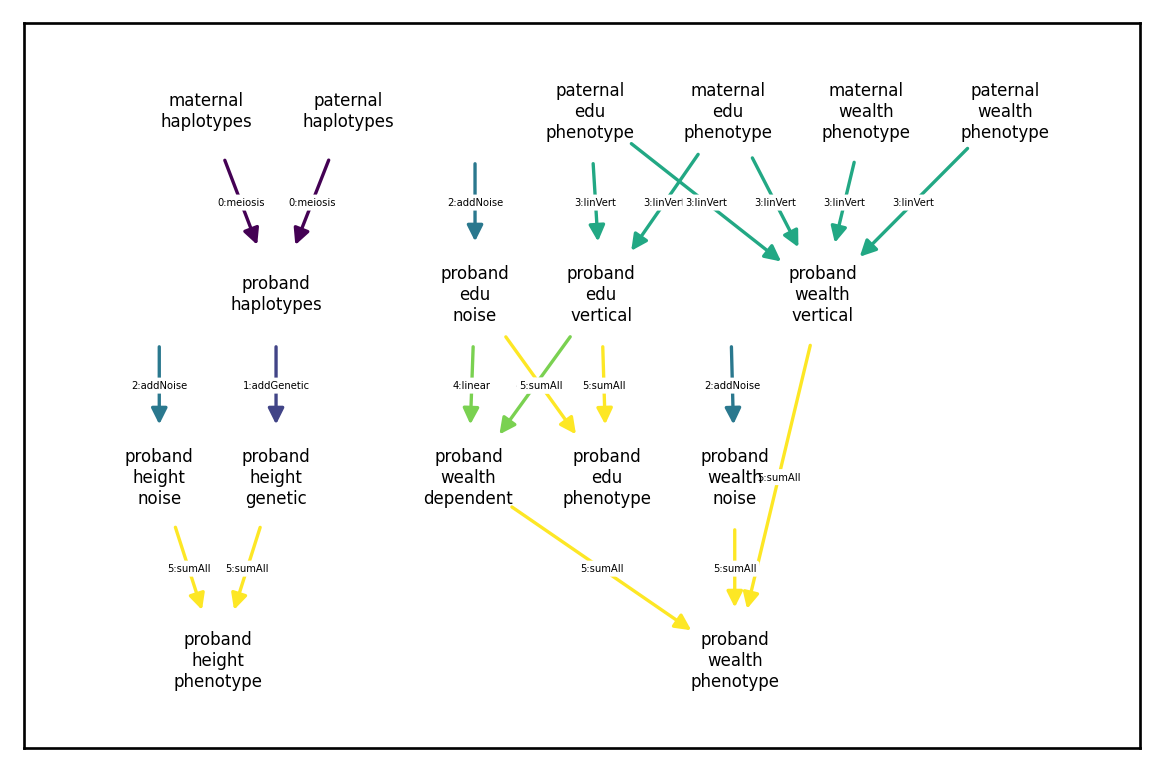

In [65]:
input_ind = xft.index.ComponentIndex.from_product(['edu'], ['noise', 'vertical'])
output_ind = xft.index.ComponentIndex(['wealth'], ['dependent'])
coefficient_matrix = np.array([[np.sqrt(1/6),np.sqrt(1/6)]])

causal_comp_redux = xft.arch.LinearTransformationComponent(input_ind, output_ind, 
                                               coefficient_matrix, normalize = True)
input_cindex=xft.index.ComponentIndex(['height','height','edu', 'edu', 'wealth', 'wealth','wealth'], 
                                      ['genetic','noise','noise', 'vertical', 'noise', 'vertical','dependent'])

strans = xft.arch.SumAllTransformation(input_cindex)

arch_redux1 = xft.arch.Architecture([genetic_comp,
                                     noise_comp,
                                     vt_comp,
                                     causal_comp_redux,
                                     strans])
arch_redux1.draw_dependency_graph(font_size=5, node_size=1000)

We can tell that there are no circular dependencies because all directed paths through the network travel through each color at most once. An alternative method for avoid circular dependences would be to keep the dependence between `wealth dependent` and `edu phenotype` but compute the sums in two steps:

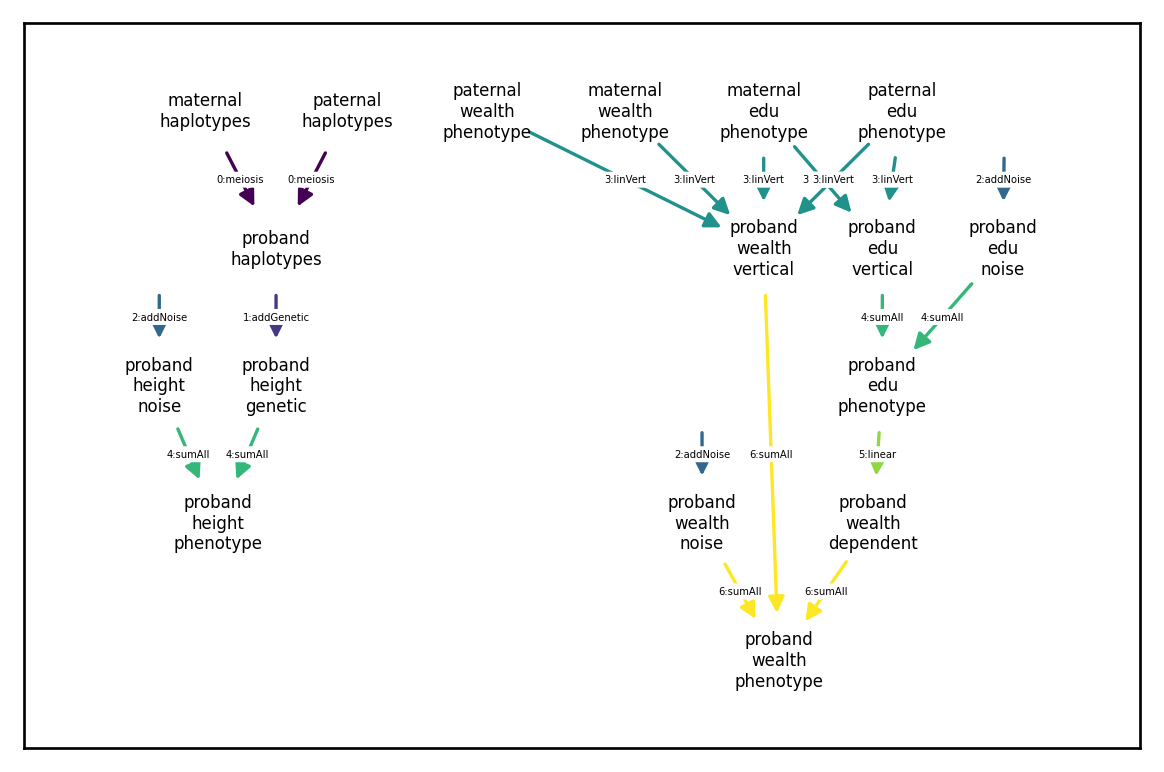

In [66]:
input_cindex=xft.index.ComponentIndex(['height','height','edu', 'edu'], 
                                      ['genetic','noise','noise', 'vertical'])

strans_redux1 = xft.arch.SumAllTransformation(input_cindex)
                                                                   
input_cindex=xft.index.ComponentIndex(['wealth', 'wealth','wealth'], 
                                      ['noise', 'vertical','dependent'])

strans_redux2 = xft.arch.SumAllTransformation(input_cindex)
                                                                                                  
                                                                   
arch_redux2 = xft.arch.Architecture([genetic_comp,
                                     noise_comp,
                                     vt_comp,
                                     strans_redux1,
                                     causal_comp,
                                     strans_redux2])
arch_redux2.draw_dependency_graph(font_size=5, node_size=800)

Both of these reformulations are equivalent and will produce expected results:

In [67]:
sim_redux1 = xft.sim.Simulation(architecture=arch_redux1,
                   founder_haplotypes=founder_haplotypes,
                   recombination_map=rmap,
                   mating_regime=mating,
                   statistics=[xft.stats.SampleStatistics(),
                               xft.stats.MatingStatistics(),
                               xft.stats.HasemanElstonEstimator(randomized=True)])
sim_redux1.run(1)
sim_redux1.phenotypes.xft.as_pd()

phenotype_name       height                 edu    wealth       edu            \
component_name      genetic     noise     noise     noise phenotype             
vorigin_relative    proband   proband   proband   proband    mother    father   
iid    fid    sex                                                               
0_0    0_0    0   -1.438016  0.022544  0.226481 -0.401393  0.259263 -0.718840   
0_1    0_1    1   -0.736997 -0.709360  0.207235  1.305485 -0.419002 -0.305199   
0_2    0_2    0    0.446289  0.000317  0.583291  0.297059 -0.388155 -0.475625   
0_3    0_3    1    0.598749  0.631816  0.763805  0.224540  0.887001 -0.066318   
0_4    0_4    0    0.107083 -0.100697 -1.346528 -1.032305 -0.665550 -1.606987   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1    0.949581 -0.128967  0.701423  0.030738 -0.697567  0.578676   
0_3996 0_3996 0    0.221268 -0.445357 -0.030676 -0.542698 -1.301182 -0.069083   
0_3997 0_3997 1   -0.748438 -0.340885 -0.007970 -0.179238  1.417744 -2.113984   
0_3998 0_3998 0    0.092972 -0.275065 -0.709992  0.335171  0.003503 -1.481524   
0_3999 0_3999 1    1.053690 -1.108479 -0.283823  0.423600  0.765778  0.111570   

phenotype_name       wealth                 edu    wealth              height  \
component_name    phenotype            vertical  vertical dependent phenotype   
vorigin_relative     mother    father   proband   proband   proband   proband   
iid    fid    sex                                                               
0_0    0_0    0    0.275651  0.491039 -0.270706  0.111543  0.017867 -1.415473   
0_1    0_1    1    0.793353  0.790677 -0.427210  0.338478 -0.075371 -1.446357   
0_2    0_2    0   -2.320184  0.099602 -0.508176 -1.290409  0.151372  0.446606   
0_3    0_3    1    2.419491 -1.237689  0.475645  0.811153  0.779896  1.230565   
0_4    0_4    0   -2.065263 -0.466361 -1.327750 -1.998314 -1.639819  0.006386   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1    2.129675 -0.888877 -0.076681  0.444898  0.454790  0.820614   
0_3996 0_3996 0    0.498826 -0.367658 -0.806152 -0.529443 -0.437410 -0.224089   
0_3997 0_3997 1   -0.612021  0.838208 -0.403473 -0.205707 -0.216612 -1.089323   
0_3998 0_3998 0    0.759984 -0.039525 -0.863432 -0.326565 -0.950433 -0.182093   
0_3999 0_3999 1   -0.280947 -1.295658  0.508071 -0.305474  0.050088 -0.054789   

phenotype_name          edu    wealth  
component_name    phenotype phenotype  
vorigin_relative    proband   proband  
iid    fid    sex                      
0_0    0_0    0   -0.044225 -0.271982  
0_1    0_1    1   -0.219975  1.568592  
0_2    0_2    0    0.075116 -0.841977  
0_3    0_3    1    1.239450  1.815588  
0_4    0_4    0   -2.674277 -4.670438  
...                     ...       ...  
0_3995 0_3995 1    0.624741  0.930426  
0_3996 0_3996 0   -0.836827 -1.509550  
0_3997 0_3997 1   -0.411443 -0.601557  
0_3998 0_3998 0   -1.573424 -0.941826  
0_3999 0_3999 1    0.224248  0.168214  

[4000 rows x 14 columns]

In [68]:
sim_redux2 = xft.sim.Simulation(architecture=arch_redux2,
                   founder_haplotypes=founder_haplotypes,
                   recombination_map=rmap,
                   mating_regime=mating,
                   statistics=[xft.stats.SampleStatistics(),
                               xft.stats.MatingStatistics(),
                               xft.stats.HasemanElstonEstimator(randomized=True)])
sim_redux2.run(1)
sim_redux2.phenotypes.xft.as_pd()

phenotype_name       height                 edu    wealth       edu            \
component_name      genetic     noise     noise     noise phenotype             
vorigin_relative    proband   proband   proband   proband    mother    father   
iid    fid    sex                                                               
0_0    0_0    0   -1.438016 -0.329891 -0.700503 -0.384676 -1.832811 -0.269002   
0_1    0_1    1   -0.736997  0.103023  0.614825 -0.002369 -0.804692 -0.105036   
0_2    0_2    0    0.446289 -0.174488  0.719350  0.029770 -0.853924 -0.169870   
0_3    0_3    1    0.598749 -0.232672 -0.756771 -0.722179  0.349305 -1.463552   
0_4    0_4    0    0.107083 -0.465606  0.083921 -0.863775 -1.073476  0.061082   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1    0.949581  0.583508 -1.255840 -0.566663  0.337588  0.488269   
0_3996 0_3996 0    0.221268 -0.945072 -1.118071 -0.894754  0.080724  0.223454   
0_3997 0_3997 1   -0.748438  0.744850 -0.573744  0.748122  0.462763  1.638921   
0_3998 0_3998 0    0.092972 -0.828753 -0.742159 -0.330774  0.439651  0.813180   
0_3999 0_3999 1    1.053690 -0.374907  0.084687 -0.239426  0.171724  0.777036   

phenotype_name       wealth                 edu    wealth    height       edu  \
component_name    phenotype            vertical  vertical phenotype phenotype   
vorigin_relative     mother    father   proband   proband   proband   proband   
iid    fid    sex                                                               
0_0    0_0    0    0.936255  0.397742 -1.219199 -0.315985 -1.767908 -1.919702   
0_1    0_1    1    1.219227 -0.186948 -0.527717  0.047452 -0.633974  0.087108   
0_2    0_2    0   -0.548014 -1.466584 -0.593694 -1.246482  0.271801  0.125656   
0_3    0_3    1    0.427493 -1.264797 -0.641249 -0.799447  0.366077 -1.398020   
0_4    0_4    0   -1.210497 -1.561846 -0.587961 -1.551647 -0.358523 -0.504040   
...                     ...       ...       ...       ...       ...       ...   
0_3995 0_3995 1    2.587558  0.768655  0.477669  1.709612  1.533088 -0.778172   
0_3996 0_3996 0   -0.381438  0.750998  0.175803  0.278940 -0.723804 -0.942268   
0_3997 0_3997 1   -0.308026  0.698303  1.213987  1.021259 -0.003588  0.640243   
0_3998 0_3998 0    0.403041 -0.516504  0.724319  0.464412 -0.735781 -0.017840   
0_3999 0_3999 1   -0.265552 -0.017015  0.547917  0.272947  0.678783  0.632605   

phenotype_name       wealth            
component_name    dependent phenotype  
vorigin_relative    proband   proband  
iid    fid    sex                      
0_0    0_0    0   -1.116549 -1.817210  
0_1    0_1    1    0.045815  0.090898  
0_2    0_2    0    0.068143 -1.148570  
0_3    0_3    1   -0.814386 -2.336011  
0_4    0_4    0   -0.296583 -2.712005  
...                     ...       ...  
0_3995 0_3995 1   -0.455363  0.687586  
0_3996 0_3996 0   -0.550410 -1.166224  
0_3997 0_3997 1    0.366196  2.135577  
0_3998 0_3998 0   -0.014972  0.118667  
0_3999 0_3999 1    0.361772  0.395293  

[4000 rows x 14 columns]

:::{tip}

We can give each a custom name for displaying on the dependency graph using the `component_name` argument.

:::

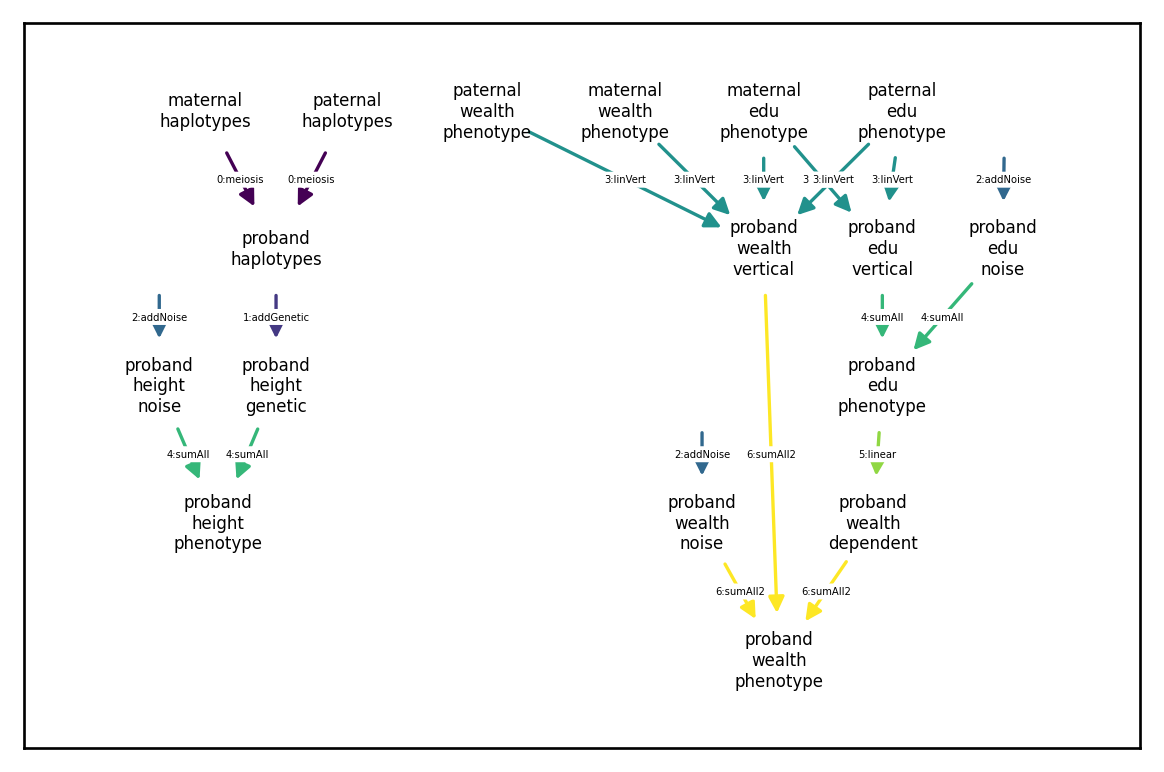

In [69]:
input_cindex=xft.index.ComponentIndex(['wealth', 'wealth','wealth'], 
                                      ['noise', 'vertical','dependent'])

strans_redux3 = xft.arch.SumAllTransformation(input_cindex,
                                              component_name='sumAll2')
                                                                                                                                                                
                                                                   
arch_redux3 = xft.arch.Architecture([genetic_comp,
                                     noise_comp,
                                     vt_comp,
                                     strans_redux1,
                                     causal_comp,
                                     strans_redux3])
arch_redux3.draw_dependency_graph(font_size=5, node_size=800)